In [28]:
'''
Max Boving

Max Boving

12/07/2025

Final Project Lin Reg

INFO 421 

'''

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split

### whole section is from the demo dataset its data cleaning/preprocessing ###
fifa = pd.read_csv('fifa.csv')

fifa = fifa.loc[:,['Value', 'foot','Age','Height','Weight','Reactions', 'Sprint Speed', 'Ball Control']]

fifa["Height_in"] = (
    fifa["Height"]
    .str.extract(r"(\d+)'\s*(\d+)") # regex expression to pull our feet ' inches 
    .astype(float)
    .apply(lambda x: x[0] * 12 + x[1], axis=1) # to inches 
)

fifa["Weight_lb"] = (
    fifa["Weight"]
    .str.replace("lbs", "", case=False) # get rid of 'lbs' substr
    .str.replace("lb", "", case=False) # get rid of 'lb' substr
    .str.strip()
    .astype(float)
)
fifa["BMI"] = (fifa["Weight_lb"] / (fifa["Height_in"] ** 2)) * 703


def parse_value(val, exchange_rate=1.08): # exchange from euro to us dollar
    val = val.replace("€", "").strip()
    if val.endswith("M"): # switch M = million to actual number 
        num = float(val[:-1]) * 1_000_000
    elif val.endswith("K") or val.endswith("k"): # same here but for thousands 
        num = float(val[:-1]) * 1_000
    else: 
        num = float(val)
    return num * exchange_rate

fifa['Value_USD'] = fifa['Value'].apply(parse_value) 
# get rid of unused cols
fifa = fifa.drop(columns=['Value', 'Weight', 'Height', 'Weight_lb', 'Height_in'])
# one hot encode our foot column --> foot_Left and foot_Right 
fifa_enc = pd.get_dummies(fifa, columns=['foot'], drop_first=False)

fifa = fifa_enc[fifa_enc["Value_USD"] != 0].copy()


/var/folders/jk/9vhbzfrn09nb63s0qxjfzmjw0000gn/T/ipykernel_82916/2178534942.py:24: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  fifa = pd.read_csv('fifa.csv')


## EDA 
### Which predictors to use ? 


In [2]:
fifa.describe()

,Age,Reactions,Sprint Speed,Ball Control,BMI,Value_USD
count,18730.000000,18730.000000,18730.000000,18730.000000,18730.000000,1.873000e+04
mean,25.132141,61.610091,64.421516,58.519434,22.809040,2.439272e+06
std,4.676324,9.070201,14.633208,16.546866,1.375983,5.534852e+06
min,16.000000,24.000000,12.000000,5.000000,17.359796,5.400000e+03
25%,21.000000,56.000000,57.000000,54.000000,21.853392,3.240000e+05
50%,25.000000,62.000000,67.000000,63.000000,22.782407,7.020000e+05
75%,28.000000,68.000000,74.000000,69.000000,23.702584,1.944000e+06
max,43.000000,95.000000,96.000000,96.000000,34.863061,1.139400e+08


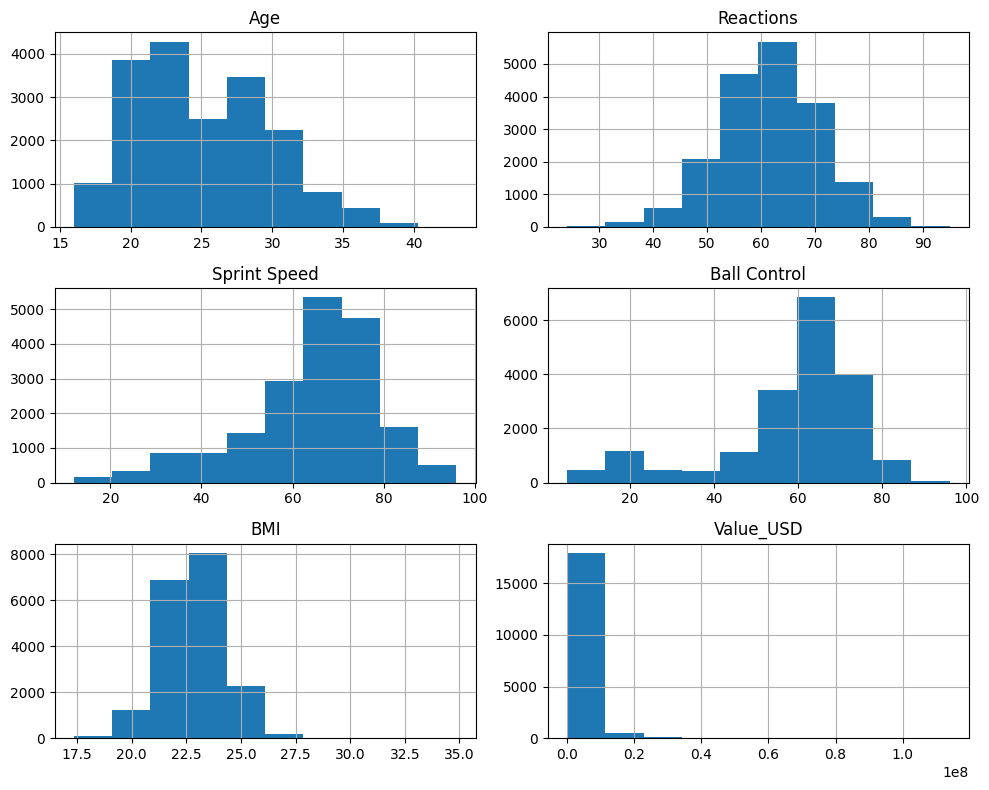

In [29]:
fifa.hist(figsize=(10, 8))
plt.tight_layout()

In [30]:
fifa.corr()


,Age,Reactions,Sprint Speed,Ball Control,BMI,Value_USD,foot_Left,foot_Right
Age,1.000000,0.457580,-0.132389,0.093127,0.267275,0.094024,-0.004474,0.004474
Reactions,0.457580,1.000000,0.194553,0.453647,0.169671,0.565956,0.016210,-0.016210
Sprint Speed,-0.132389,0.194553,1.000000,0.674964,-0.056064,0.182326,0.112719,-0.112719
Ball Control,0.093127,0.453647,0.674964,1.000000,0.006020,0.303471,0.106721,-0.106721
BMI,0.267275,0.169671,-0.056064,0.006020,1.000000,0.066305,-0.024257,0.024257
Value_USD,0.094024,0.565956,0.182326,0.303471,0.066305,1.000000,0.021418,-0.021418
foot_Left,-0.004474,0.016210,0.112719,0.106721,-0.024257,0.021418,1.000000,-1.000000
foot_Right,0.004474,-0.016210,-0.112719,-0.106721,0.024257,-0.021418,-1.000000,1.000000


    As we can see, the more technical attributes like 'Ball Control', 'Reactions', greatly outpower the physical features , height/weight/foot . So I will update the final feature set to be "Reactions", "Sprint Speed", "Ball Control". 

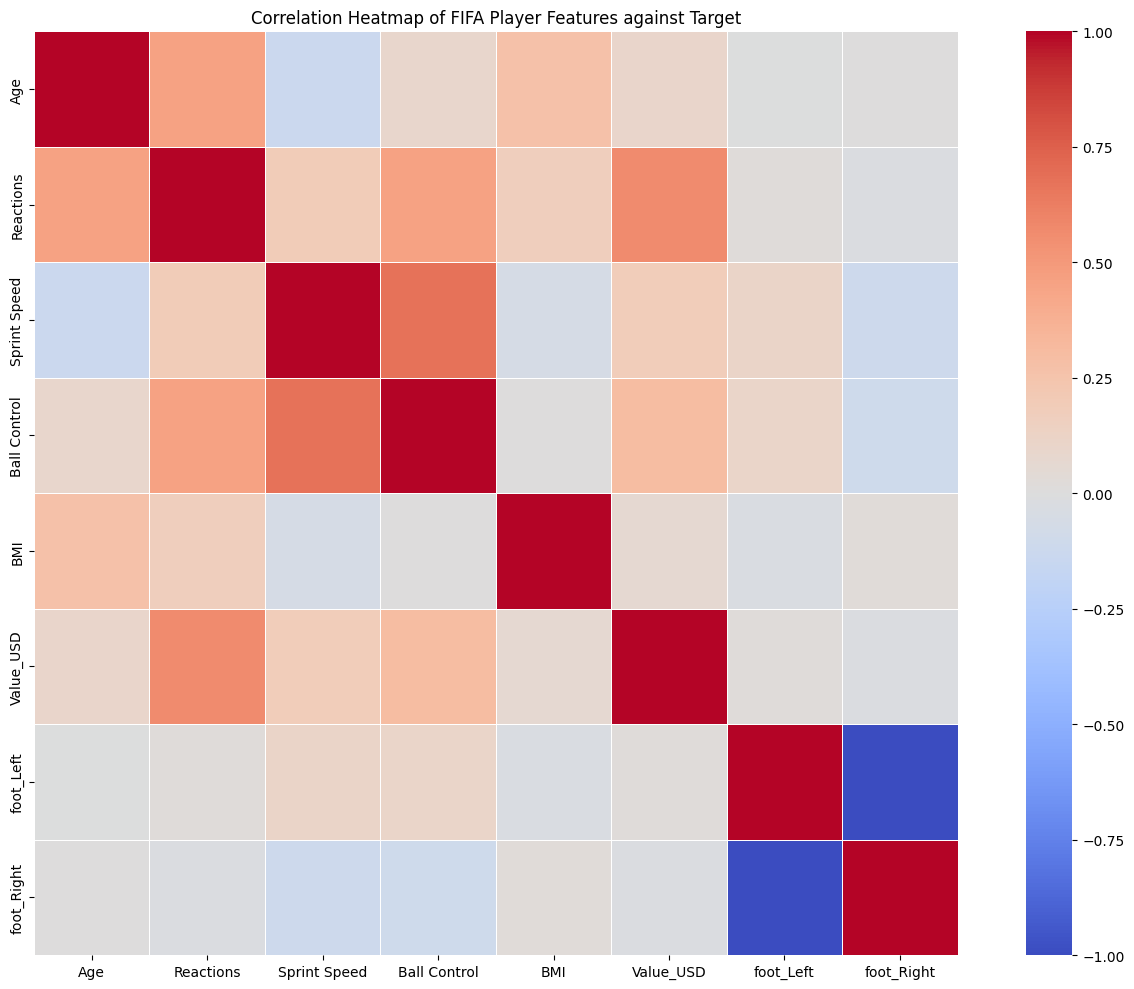

In [31]:
corr = fifa.corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Heatmap of FIFA Player Features against Target")
plt.tight_layout()
plt.show()

   ## Feature Set Scaling and Transformations
      determine if anything needs to be done

In [32]:
fifa[["Reactions", "Ball Control", "Sprint Speed"]].describe()


,Reactions,Ball Control,Sprint Speed
count,18730.000000,18730.000000,18730.000000
mean,61.610091,58.519434,64.421516
std,9.070201,16.546866,14.633208
min,24.000000,5.000000,12.000000
25%,56.000000,54.000000,57.000000
50%,62.000000,63.000000,67.000000
75%,68.000000,69.000000,74.000000
max,95.000000,96.000000,96.000000


    Differences across the minimum and std dev for our features justifies standardizing our data. We will use z-score standarization. 

## Model Selection

### Is linear regression suitable for this data ? 

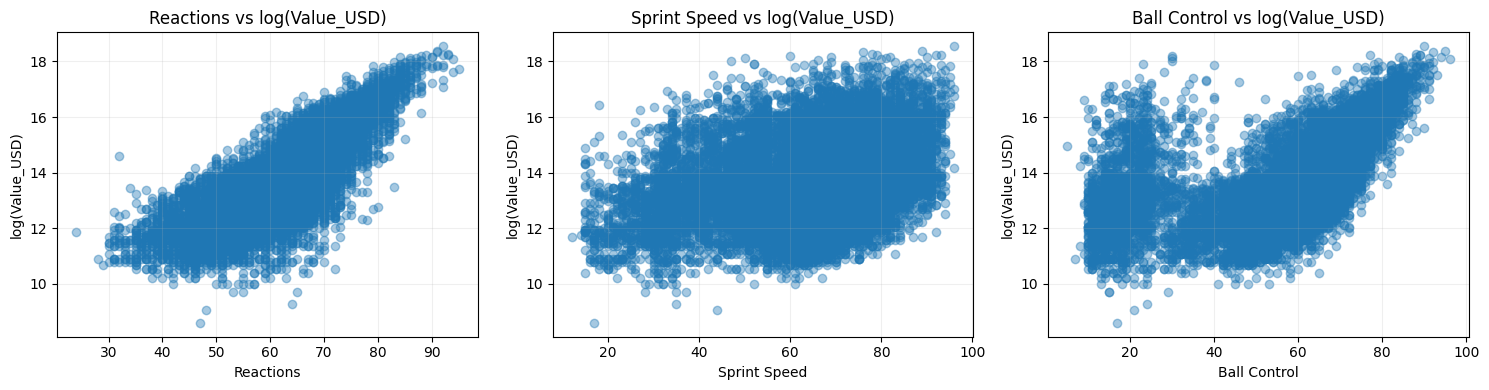

In [33]:
import matplotlib.pyplot as plt
import numpy as np

fifa["log_value"] = np.log(fifa["Value_USD"])

predictors = ["Reactions", "Sprint Speed", "Ball Control"]

plt.figure(figsize=(15,4))

for i, col in enumerate(predictors, 1):
    plt.subplot(1, 3, i)
    plt.scatter(fifa[col], fifa["log_value"], alpha=0.4)
    plt.title(f"{col} vs log(Value_USD)")
    plt.xlabel(col)
    plt.ylabel("log(Value_USD)")
    plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()


    This data is suitable for linear regression since it shows relatively linear trends between the predictors and the target variable. Additonally, the correlation frame in our EDA showed relationships between predictors and target, and correlation is a linear measure.

    Lastly, before we begin the linear regression I pruned rows where 'Ball Control' < 30 as you can see above in the scatter plot the lower values are too noisey for the simple model.

In [34]:

### begin linear regression

# addressed feature selection specifically in our EDA above
feature_cols = ["Reactions","Sprint Speed","Ball Control"]
target_col   = "Value_USD"

# slice to get our feature and target seperated
fifa_filtered = fifa[fifa["Ball Control"] > 35].copy()
print(len(fifa_filtered))
# 2. Select only the feature columns from the filtered data
X = fifa_filtered[feature_cols].copy()
y = fifa_filtered[target_col].to_numpy(dtype=float) 

# make sure our features df looks right ( it does)
print(X)

# (value usd is a numpy arr of Value_USD)
#print(y)


16535
       Reactions  Sprint Speed  Ball Control
0             94            80            96
1             95            91            92
3             91            76            92
4             91            89            95
5             93            78            88
...          ...           ...           ...
18973         51            60            48
18975         53            70            44
18976         46            60            42
18977         51            64            48
18978         50            59            43

[16535 rows x 3 columns]


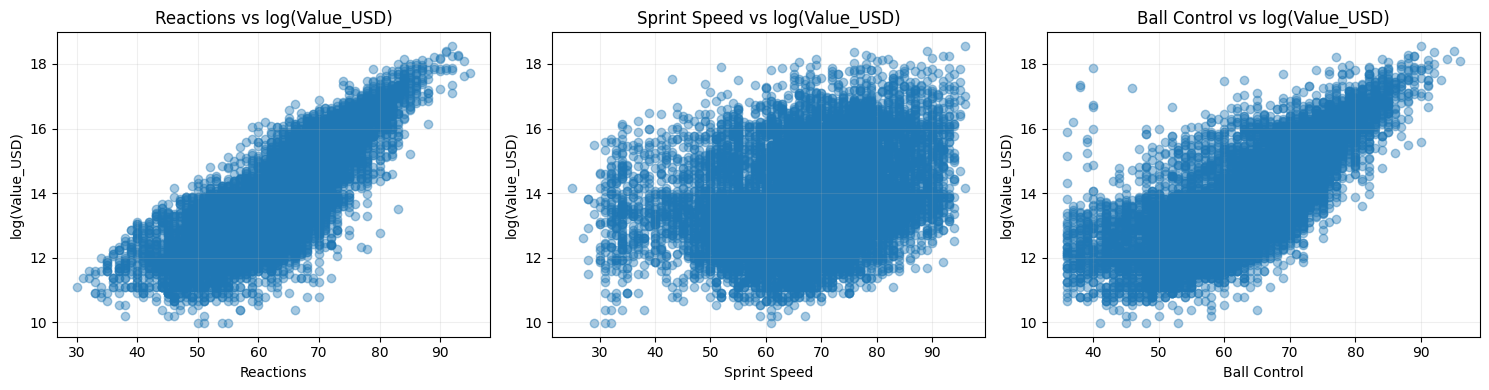

In [35]:
fifa_filtered["log_value"] = np.log(fifa_filtered["Value_USD"])

predictors = ["Reactions", "Sprint Speed", "Ball Control"]

plt.figure(figsize=(15,4))

for i, col in enumerate(predictors, 1):
    plt.subplot(1, 3, i)
    plt.scatter(fifa_filtered[col], fifa_filtered["log_value"], alpha=0.4)
    plt.title(f"{col} vs log(Value_USD)")
    plt.xlabel(col)
    plt.ylabel("log(Value_USD)")
    plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

In [36]:
# get the mean and std dev for scaling
# scaling is important as a pre prediction step here because our data features have different ranges
# scaling will help make our coefficient results much more interpretable ( all coeffs will be on the same scale)
# log transform our target since the data is skewed( described in my dataset_demo notebook)
logy = np.log(y)

# split our data so we can train and then test it later ( I used a 90/10 split)
# also getting indexes saved here so I can re-align the preds with true in a df after
X_train_df, X_test_df, y_train, y_test, idx_train, idx_test = train_test_split(
    X, logy, X.index.to_numpy(),
    test_size=0.1, random_state=42
)

# ddof gives us population std (our population is assumed as the training set)
mean = X_train_df.mean().to_numpy()
std  = X_train_df.std(ddof=0).to_numpy()

# avoid divide-by-zero if any column has zero variance
std[std == 0] = 1

# z-score scaling
X_train = (X_train_df.to_numpy(dtype=float) - mean) / std
X_test  = (X_test_df.to_numpy(dtype=float) - mean) / std

n_samples, n_features = X_train.shape

# run gradient descent
# initialize our wieghts and bias level
w   = np.zeros(n_features, dtype=float) 
b   =  1.0
lr      = 0.01   
epochs  = 1000
# iterate through 1000 epochs and adj our weights and bias 
for epoch in range(epochs):
    y_hat = np.dot(X_train, w) + b           

    # compute error ( predicted - true) 
    err = y_hat - y_train                

    # gradients
    dw = (1.0 / n_samples) * np.dot(X_train.T, err)   
    db = (1.0 / n_samples) * np.sum(err)             

    # update our bias and weights
    w -= lr * dw
    b -= lr * db

print("Weights:", w)
print("Bias:", b)




Weights: [0.80930401 0.15871694 0.42648565]
Bias: 13.716440116001968


    Reactions (0.85) is the strongest predictor of player value, consistent with highest correlation in the EDA.

    Ball Control (0.388) is the next most important feature, showing positive trend on value.

    Sprint Speed (0.156) has a smaller but still positive effect

    Bias (Intercept): 13.71

In [37]:
# now predict using our test data( 10 % of original set)
y_pred = np.dot(X_test, w) + b
# mse = mean of  ( error )^2 
mse_test = np.mean((y_pred - y_test) ** 2)
print("MSE:", mse_test)
# take sqrt to get our root mse
rmse_log = np.sqrt(mse_test)         
print("RMSE:",rmse_log)
# get factor using exponential function
factor   = np.exp(rmse_log)
print("Factor :", factor)
# the factor tells us on average our predicted values are off by a factor of 2. 
# this sounds bad because if a player was valued at 1M we may guess 500k or 2M, but for a model that 
# assumes linearity and only uses a few variables this is not too bad. For context their are many other variables 
#that largely influence player value especially the club or team they play for. 

# answer my question about how much variance we explain during model prediction
# get the residual sum of squares 
rss_test = np.sum((y_test - y_pred)**2)
# get the total sum of squares
tss_test = np.sum((y_test - y_test.mean())**2)
# calc r^2
r2_test  = 1 - rss_test / tss_test
print("R^2 :", r2_test)

MSE: 0.4416699332501828
RMSE: 0.6645825255377866
Factor : 1.9436789156262733
R^2 : 0.7456914205165166


    Model explains roughly 75% of the variance in the data.
    
    Factor indicates the predicted value is within a factor of two from the true value. For a 3 feature model, this is pretty good because valuation can also be very noisy(hype, injuries,...)

In [39]:
y_pred_s = pd.Series(y_pred, index=idx_test, name="y_pred_log")

# 2) join to the original df by index; keep only test rows; enforce test order
fifa_pred = (
    fifa[["Value_USD"]]
    # do an inner join to only return rows where the index aligns (y_pred_s.index, fifa.index)
    .join(y_pred_s, how="inner")   
    .reindex(idx_test) # reindex on orig index to preserve order
    .reset_index() # then reset index so we get normal x axis ticks
)

# turn our y_pred_log back to dollars
fifa_pred["Predicted_Value_USD"] = np.exp(fifa_pred["y_pred_log"])
# get rid of the log col
fifa_pred = fifa_pred.drop(columns=['y_pred_log', 'index'])

fifa_pred

,Value_USD,Predicted_Value_USD
0,351000.0,2.522514e+06
1,11880000.0,1.052188e+07
2,324000.0,6.212973e+05
3,378000.0,9.967087e+04
4,810000.0,1.273040e+06
...,...,...
1649,4104000.0,2.207224e+06
1650,3240000.0,1.472981e+06
1651,5184000.0,4.609805e+06
1652,81540000.0,2.417313e+07


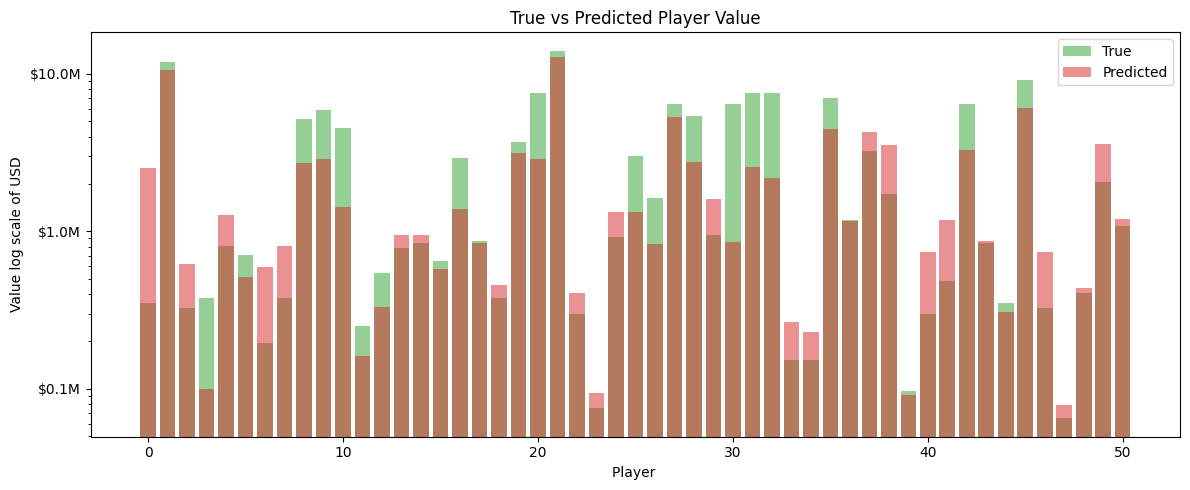

In [41]:
fifa_pred = fifa_pred.loc[:50,:].copy(0)
n_samples = len(fifa_pred)

x = np.arange(n_samples)
# get our cols 
y_true = fifa_pred["Value_USD"].to_numpy(float)
y_pred = fifa_pred["Predicted_Value_USD"].to_numpy(float)


plt.figure(figsize=(12,5))
plt.bar(x, y_true, alpha=0.5, label="True", color="tab:green")
plt.bar(x, y_pred, alpha=0.5, label="Predicted", color="tab:red")

ax = plt.gca()
# Pretty tick labels in $M on a log axis for better comparison ( huge y range on that last plot (35M - 500k))
ax.set_yscale("log")
#docs: https://matplotlib.org/stable/gallery/ticks/tick-formatters.html
# used a lambda func to apply the scale to yticks 
# this f-string just prints the number as dollars in millions with commas and 1 decimal (35000000 -> "$35.0M")
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f'${v/1e6:,.1f}M'))
plt.ylabel("Value log scale of USD")
plt.xlabel("Player ")
plt.title("True vs Predicted Player Value")
plt.legend()
plt.tight_layout()
plt.show()